# Le profil des loueurs influence-t-il le potentiel locatif d’un bien ?

**Objectif** : évaluer le lien entre le loueur et le potentiel locatif de son logement :

- Obtenir une description plus complète des loueurs à partir de leurs photos : estimer le genre et l'âge du loueur à partir de l'image associée à son compte.
- Extraire de l’information de la présentation textuelle et du nom d'utilisateur des loueurs à l'aide des méthodes de traitement du language.
* Utiliser l’ensemble des informations obtenues pour évaluer l’existence d’un lien entre le profil des loueurs et les différentes variables de la base (prix, type de bien loué,...)

Attention, ce sujet est sensible, il doit être traité avec la plus grande prudence. En particulier, suite à la discussion pendant la présentation des sujets nous n'encourageons pas la détection de l'origine ethnique sur les images des loueurs.


Avant de commencer, vous devez executer ces lignes dans un terminal pour éviter des bugs avec deepface

- pip uninstall protobuf python3-protobuf
- pip install --upgrade protobuf
- sudo apt-get update ##[edited]
- sudo apt-get install ffmpeg libsm6 libxext6  -y

In [5]:
!pip install -q -q -q  deepface
!pip install -q -q -q wget

# Reconnaissance de l'âge et du genre des loueurs (hosts)

On utilise dans ce notebook, le package deepface pour estimer l'age, le genre et l'ethnie des loueurs. Pour ce faire, ce package incorpore deux étapes : détection des visages, puis application d'un réseau de neurones (à l'aide de Keras et de Tensorflow) pour déterminer les caractéristiques des visages. 

In [26]:
import requests
from io import BytesIO
import urllib.request

import os

import s3fs

from deepface import DeepFace
import pandas as pd

Je charge les modéles pré-entrainés de détection de visage, d'âge et de genre.

In [37]:
urllib.request.urlretrieve('https://minio.lab.sspcloud.fr/projet-funathon/diffusion/retinaface.h5', '/root/.deepface/weights/retinaface.h5')
urllib.request.urlretrieve('https://minio.lab.sspcloud.fr/projet-funathon/diffusion/age_model_weights.h5', '/root/.deepface/weights/age_model_weights.h5')
urllib.request.urlretrieve('https://minio.lab.sspcloud.fr/projet-funathon/diffusion/gender_model_weights.h5', '/root/.deepface/weights/gender_model_weights.h5')

('/root/.deepface/weights/gender_model_weights.h5',
 <http.client.HTTPMessage at 0x7f9af64132e8>)

Chargement des listings

In [6]:
fs = s3fs.S3FileSystem(client_kwargs={'endpoint_url': 'https://minio.lab.sspcloud.fr'})

In [8]:
fs.get('projet-funathon/diffusion/data/paris/2021-04-10/listings.csv.gz', 'listings.csv.gz')
listings_d = pd.read_csv('listings.csv.gz',compression='gzip')

Construction de la base des loueurs à partir du fichier des listings.

In [9]:
hosts = listings_d.groupby([ 'host_id', 'host_url',
       'host_name', 'host_since', 'host_location', 'host_about',
       'host_response_time', 'host_response_rate', 'host_acceptance_rate',
       'host_is_superhost', 'host_thumbnail_url', 'host_picture_url',
       'host_neighbourhood', 'host_listings_count',
       'host_total_listings_count', 'host_verifications',
       'host_has_profile_pic', 'host_identity_verified'], as_index=False)['id'].count()

In [10]:
hosts.head(2)

host_id                                host_url host_name  host_since  \
0     2626  https://www.airbnb.com/users/show/2626    Franck  2008-08-30   
1     2827  https://www.airbnb.com/users/show/2827    Karine  2008-09-09   

                           host_location  \
0           Paris, Île-de-France, France   
1  Casablanca, Grand Casablanca, Morocco   

                                          host_about host_response_time  \
0  I am a writer,51, author of novels, books of l...     within an hour   
1  Arrivée à Casablanca il y a 4 ans, je suis amo...       within a day   

  host_response_rate host_acceptance_rate host_is_superhost  \
0               100%                  83%                 t   
1                50%                  67%                 f   

                                  host_thumbnail_url  \
0  https://a0.muscache.com/im/pictures/user/58f00...   
1  https://a0.muscache.com/im/pictures/user/17fe6...   

                                    host_picture_url host_neighbourhood  \
0  https://a0.muscache.com/im/pictures/user/58f00...          Le Marais   
1  https://a0.muscache.com/im/pictures/user/17fe6...         République   

   host_listings_count  host_total_listings_count  \
0                  4.0                        4.0   
1                  2.0                        2.0   

                                  host_verifications host_has_profile_pic  \
0  ['email', 'phone', 'reviews', 'jumio', 'offlin...                    t   
1  ['email', 'phone', 'reviews', 'jumio', 'govern...                    t   

  host_identity_verified  id  
0                      t   1  
1                      t   1

Téléchargement des 16 premières images des loueurs.

In [14]:
os.mkdir('list_images')

In [39]:
from PIL import Image
for index,row in hosts.iloc[:50,:].iterrows():
    url = row['host_picture_url']
    try:
        response = requests.get(url)
        img = Image.open(BytesIO(response.content))
        img.save('list_images/'+ str(row['host_id']) + '.jpg') 
    except:
        print('error host_id : ' + str(row['host_id']))    

In [21]:
list_images = glob.glob("list_images/*.jpg")

 Reconnaissance de l'age et du genre

In [34]:
list_objs = []
for file in list_images:
    list_objs.append(DeepFace.analyze(img_path = file, actions = ['age', 'gender'], enforce_detection=False))

Action: gender: 100%|██████████| 2/2 [00:02<00:00,  1.41s/it]


On affiche les prédictions et l'on constate que ce n'est pas satisfaisant. Comment améliorer les performances... A vous de jouer!

28  years old  Woman


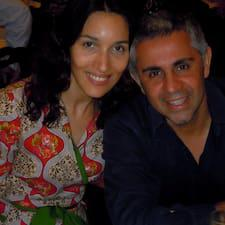

---------------------------------
43  years old  Man


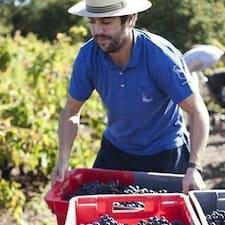

---------------------------------
31  years old  Man


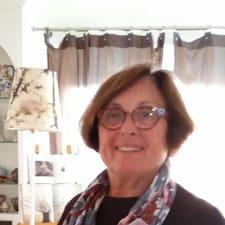

---------------------------------
23  years old  Man


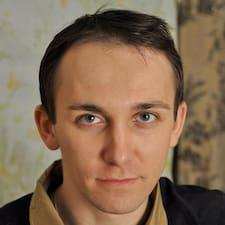

---------------------------------
30  years old  Woman


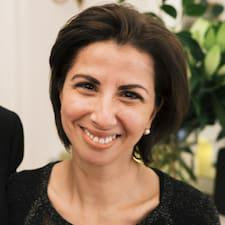

---------------------------------
32  years old  Man


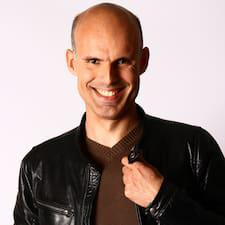

---------------------------------
36  years old  Man


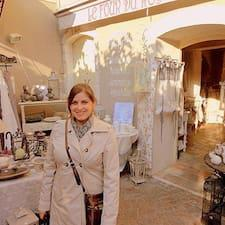

---------------------------------
33  years old  Man


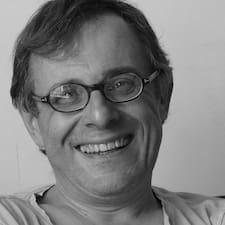

---------------------------------
31  years old  Woman


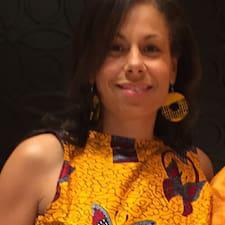

---------------------------------
24  years old  Man


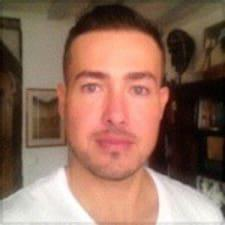

---------------------------------
33  years old  Man


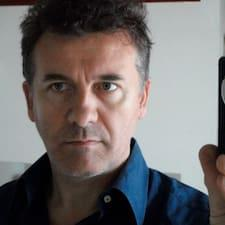

---------------------------------
39  years old  Man


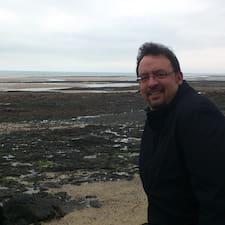

---------------------------------
33  years old  Woman


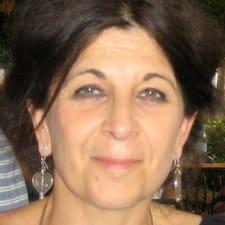

---------------------------------
31  years old  Man


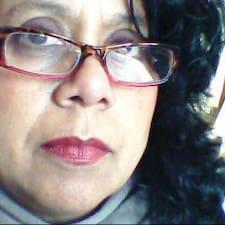

---------------------------------
31  years old  Man


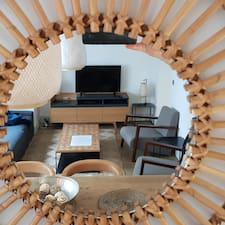

---------------------------------
36  years old  Man


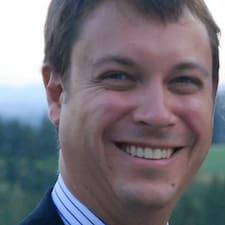

---------------------------------


In [35]:
from IPython.display import Image, display
for file,obj in zip(list_images,list_objs):
    print(obj["age"]," years old ", obj["gender"])
    display(Image(filename=file))
    print('---------------------------------')
